<a href="https://colab.research.google.com/github/mrkevinlin/MLmed/blob/master/keras_medicine_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes:
#**- Determine imputation to use**
#**- Determine measure of accuracy to use**
# **- Need to save state? DEFINITELY LOCK seeds for random splitting of data?**
# **- Document loss and errors in HDF5 format?**


# **- Visualize all data, remember data transformation**

# **Initialize everything**

In [0]:
!pip install --upgrade -q gspread

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

from __future__ import print_function

import math
from google.colab import files
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 30
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.3f}'.format


gc = gspread.authorize(GoogleCredentials.get_application_default())

# Create a DataFrame of patient data

**Import CSV to populate a DataFrame**

In [0]:
# Open Google Sheet of patient data and get column titles
patient_dataframe = gc.open('patient_data').sheet1
column_names = patient_dataframe.row_values(1)

# Process Google Sheet into a pandas dataframe of all numeric values
patient_dataframe = pd.DataFrame.from_records(
    patient_dataframe.get_all_values(),
    columns=column_names)
patient_dataframe = patient_dataframe.iloc[1:]
patient_dataframe = patient_dataframe.apply(pd.to_numeric, errors='coerce')
patient_dataframe = patient_dataframe.replace('', np.nan)
patient_dataframe_original = patient_dataframe.copy()


# **View some stats on the data**

,year,entry_knowledge,entry_hads_a,entry_hads_d,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,entry_met,entry_chol,entry_trig,entry_hdl,entry_ldl,exit_knowledge,exit_hads_a,exit_hads_d,exit_weight,exit_waist,exit_BF,exit_BMI,exit_6mwt,exit_met,exit_chol,exit_trig,exit_hdl,exit_ldl
count,566.000,478.000,487.000,411.000,441.000,523.000,506.000,491.000,407.000,376.000,487.000,330.000,330.000,328.000,323.000,118.000,121.000,88.000,123.000,123.000,121.000,86.000,80.000,124.000,97.000,97.000,98.000,98.000
mean,2016.756,67.383,5.072,5.088,66.714,192.452,39.385,29.948,30.313,1083.535,2.551,159.458,135.733,47.384,88.077,73.924,3.479,2.682,187.728,38.219,27.508,29.002,1493.312,3.263,150.948,107.546,54.112,76.755
std,1.149,20.886,4.413,4.316,4.378,47.627,5.889,8.189,6.552,392.374,0.513,47.339,130.403,15.538,37.438,19.176,3.349,3.124,43.234,5.480,7.540,5.250,351.040,0.682,41.186,59.681,17.704,30.487
min,2015.000,0.000,0.000,0.000,54.250,90.600,24.000,9.000,17.000,200.000,1.100,51.000,33.000,11.000,7.000,15.000,0.000,0.000,121.600,27.250,15.900,19.310,300.000,1.400,69.000,43.000,31.000,24.000
25%,2016.000,54.000,1.000,2.000,63.750,159.150,35.500,23.705,25.120,900.000,2.300,127.250,76.000,36.000,61.000,62.000,0.000,0.000,156.800,34.750,21.800,24.150,1361.250,2.900,124.000,72.000,41.000,54.000
50%,2017.000,69.000,4.000,4.000,66.800,184.500,38.750,29.500,29.100,1100.000,2.600,152.000,107.000,45.000,84.000,77.000,3.000,2.000,182.400,37.500,26.810,28.300,1525.000,3.200,144.000,94.000,50.000,72.000
75%,2018.000,85.000,8.000,8.000,70.000,218.200,43.000,36.000,34.375,1276.000,2.900,184.750,153.000,56.000,106.500,92.000,6.000,4.000,209.500,41.250,32.200,33.147,1701.000,3.625,167.000,121.000,61.750,92.500
max,2019.000,100.000,21.000,21.000,79.000,399.200,64.500,50.000,62.300,5422.000,6.500,342.000,1549.000,100.000,245.000,100.000,13.000,14.000,299.600,64.000,43.820,40.720,2189.000,6.200,289.000,389.000,118.000,169.000



Number missing in each column:


year                 0
entry_knowledge     88
entry_hads_a        79
entry_hads_d       155
entry_height       125
entry_weight        43
entry_waist         60
entry_BF            75
entry_BMI          159
entry_6mwt         190
entry_met           79
entry_chol         236
entry_trig         236
entry_hdl          238
entry_ldl          243
exit_knowledge     448
exit_hads_a        445
exit_hads_d        478
exit_weight        443
exit_waist         443
exit_BF            445
exit_BMI           480
exit_6mwt          486
exit_met           442
exit_chol          469
exit_trig          469
exit_hdl           468
exit_ldl           468
dtype: int64

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


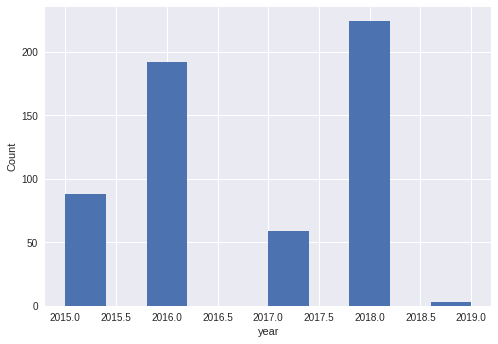

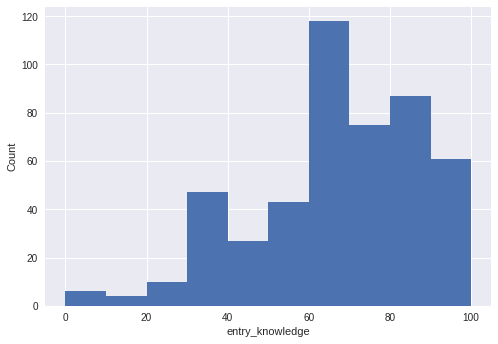

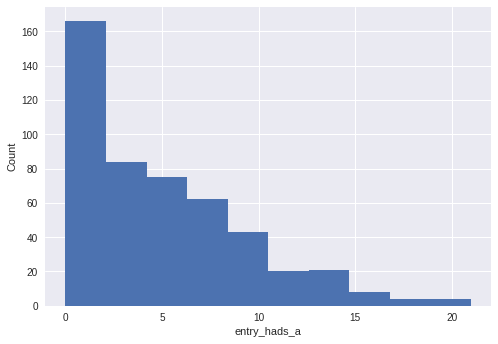

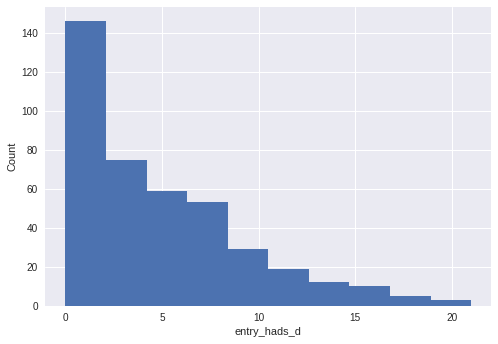

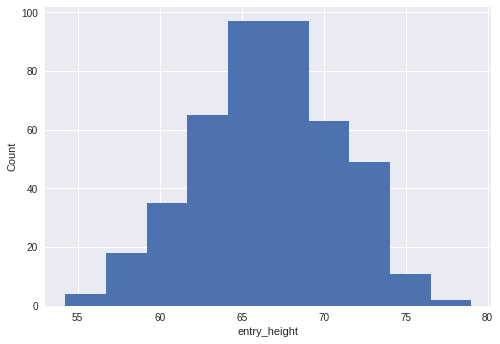

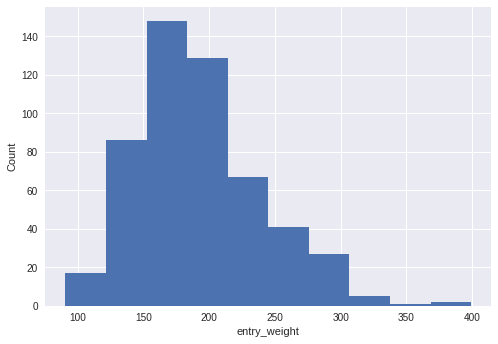

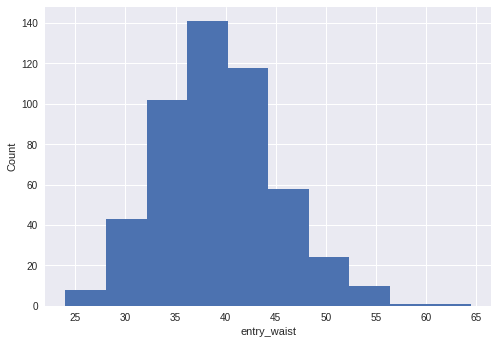

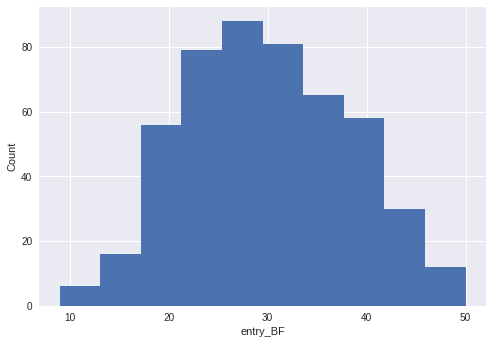

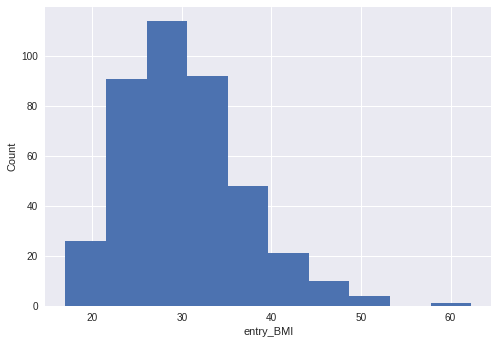

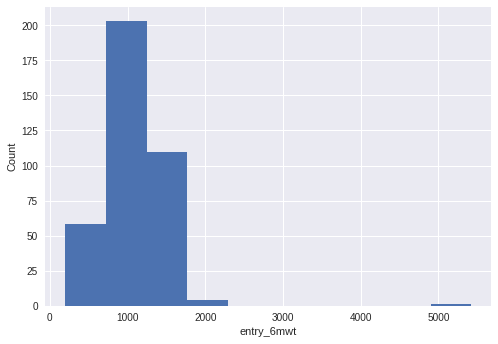

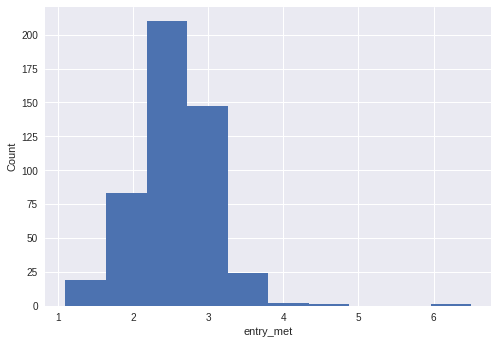

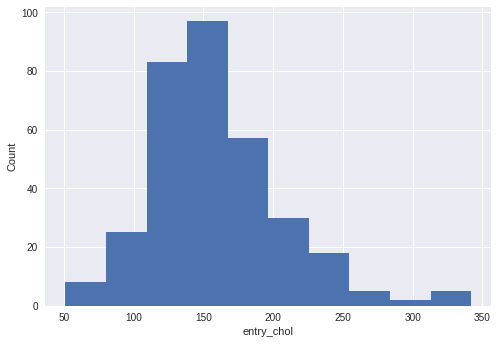

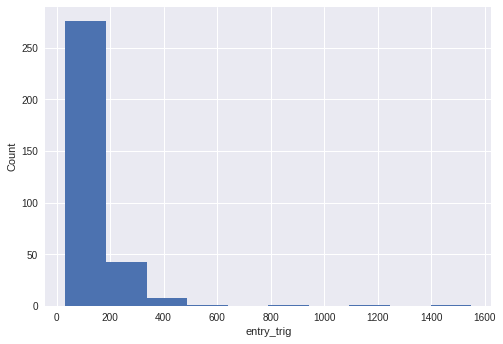

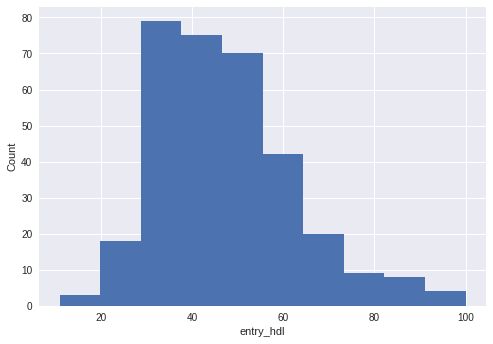

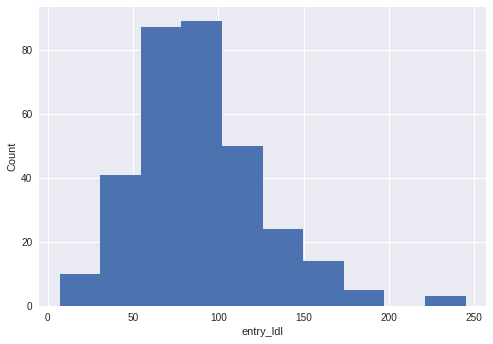

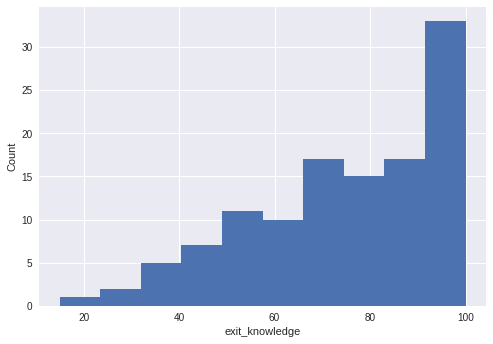

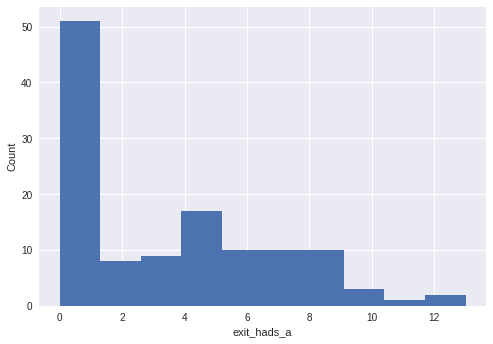

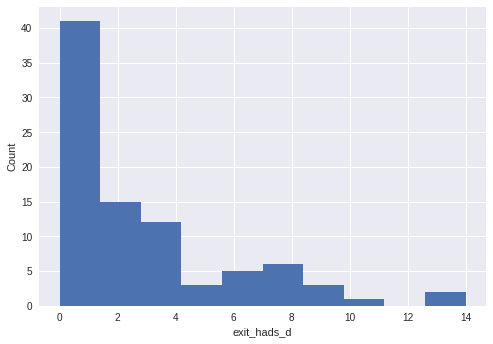

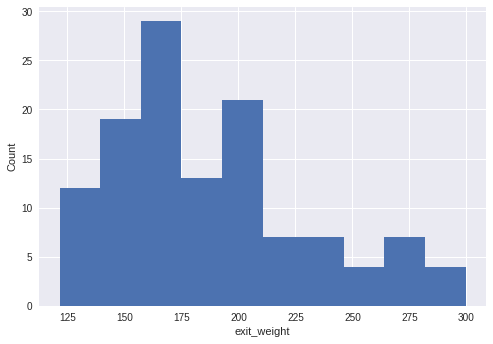

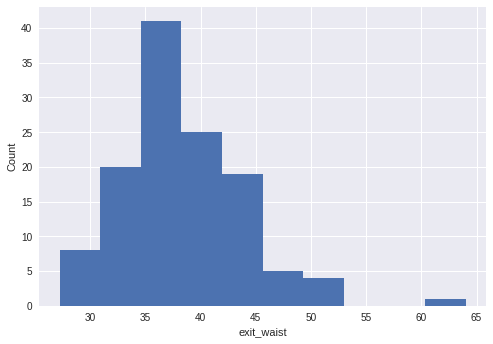

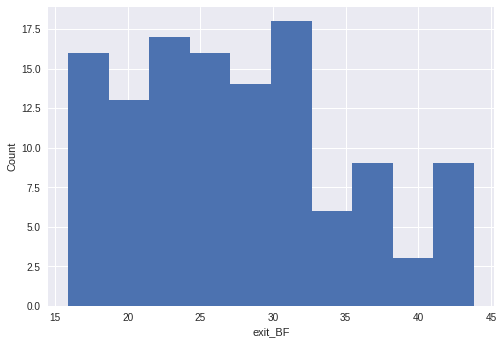

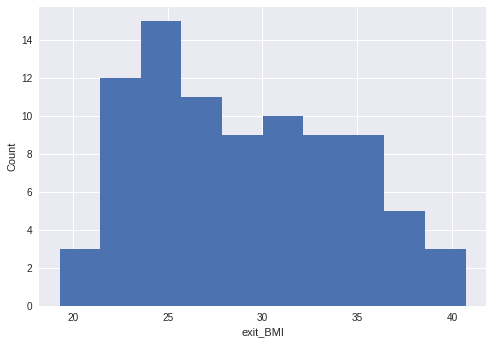

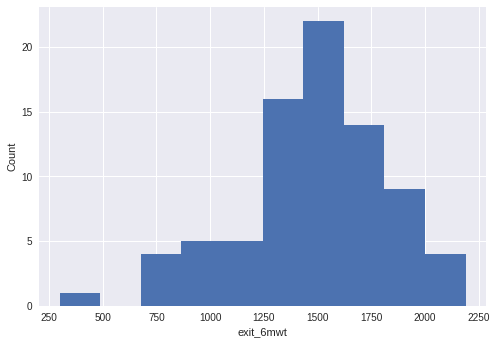

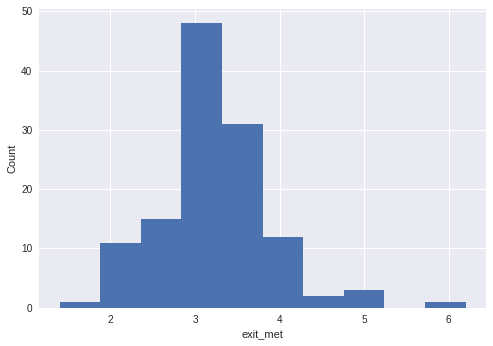

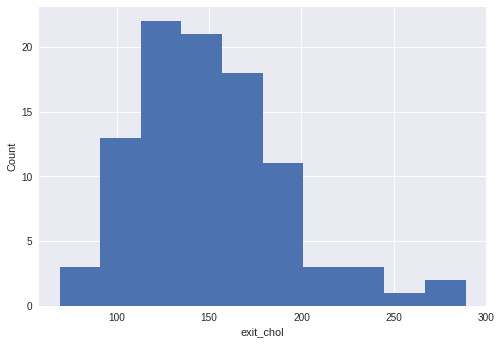

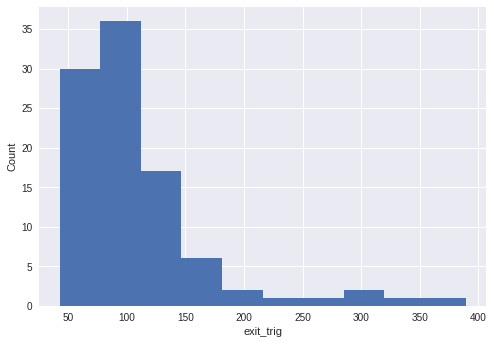

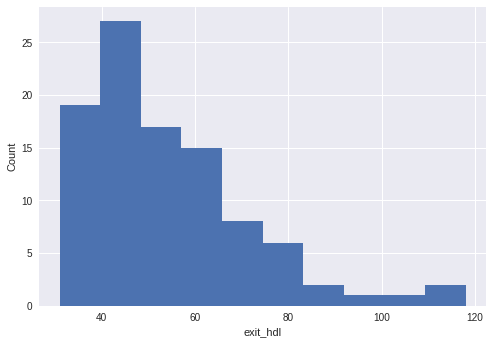

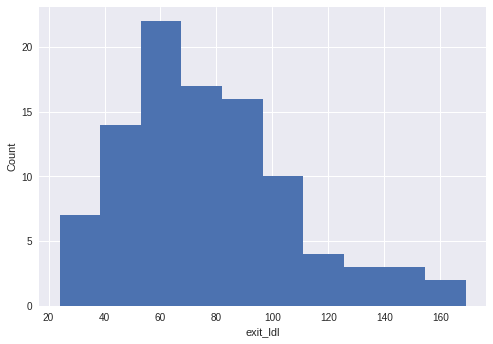

In [0]:
def view_stats(df):
  plt.close('all')
  display.display(df.describe())
  print("\nNumber missing in each column:")
  display.display(df.isna().sum())

  plt.close('all')
  for col in df.columns:
    plt.figure()
    plt.hist(df[col])
    plt.xlabel(col)
    plt.ylabel("Count")

view_stats(patient_dataframe)

# **Pick features and labels to use and create methods for cleaning up data**

In [0]:
# Close the matlib plots from view stats to reduce memory usage
plt.close('all')

def clean_up_data(df):
  edited_df = df.copy()
  edited_df = create_features(edited_df)
  return edited_df

# Create synthetic features
def create_features(df):
  df = create_target(df)
  df = create_hads_bins(df)
  return df

# Create target label of change in 6MWT results  
def create_target(df):
  df['delta_6mwt'] = (df['exit_6mwt'] - df['entry_6mwt'])
  return df
  
# Create categorical bins of anxiety and depression scale
def create_hads_bins(df):
  hads_bins=[0,7,10,21]
  anxiety_df = pd.get_dummies(pd.cut(df['entry_hads_a'], bins=hads_bins, labels=['normal_a', 'borderline_a', 'anxiety']))
  depression_df = pd.get_dummies(pd.cut(df['entry_hads_d'], bins=hads_bins, labels=['normal_d', 'borderline_d', 'depression']))
  df = df.join(anxiety_df).join(depression_df)
  display.display(df.describe())
  
edit_df = clean_up_data(patient_dataframe)
#edit_df.describe()

,year,entry_knowledge,entry_hads_a,entry_hads_d,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,entry_met,entry_chol,entry_trig,entry_hdl,entry_ldl,exit_knowledge,exit_hads_a,exit_hads_d,exit_weight,exit_waist,exit_BF,exit_BMI,exit_6mwt,exit_met,exit_chol,exit_trig,exit_hdl,exit_ldl,delta_6mwt,normal_a,borderline_a,anxiety,normal_d,borderline_d,depression
count,566.000,478.000,487.000,411.000,441.000,523.000,506.000,491.000,407.000,376.000,487.000,330.000,330.000,328.000,323.000,118.000,121.000,88.000,123.000,123.000,121.000,86.000,80.000,124.000,97.000,97.000,98.000,98.000,80.000,566.000,566.000,566.000,566.000,566.000,566.000
mean,2016.756,67.383,5.072,5.088,66.714,192.452,39.385,29.948,30.313,1083.535,2.551,159.458,135.733,47.384,88.077,73.924,3.479,2.682,187.728,38.219,27.508,29.002,1493.312,3.263,150.948,107.546,54.112,76.755,401.881,0.479,0.118,0.101,0.475,0.097,0.087
std,1.149,20.886,4.413,4.316,4.378,47.627,5.889,8.189,6.552,392.374,0.513,47.339,130.403,15.538,37.438,19.176,3.349,3.124,43.234,5.480,7.540,5.250,351.040,0.682,41.186,59.681,17.704,30.487,248.319,0.500,0.323,0.301,0.500,0.296,0.281
min,2015.000,0.000,0.000,0.000,54.250,90.600,24.000,9.000,17.000,200.000,1.100,51.000,33.000,11.000,7.000,15.000,0.000,0.000,121.600,27.250,15.900,19.310,300.000,1.400,69.000,43.000,31.000,24.000,-395.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2016.000,54.000,1.000,2.000,63.750,159.150,35.500,23.705,25.120,900.000,2.300,127.250,76.000,36.000,61.000,62.000,0.000,0.000,156.800,34.750,21.800,24.150,1361.250,2.900,124.000,72.000,41.000,54.000,260.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2017.000,69.000,4.000,4.000,66.800,184.500,38.750,29.500,29.100,1100.000,2.600,152.000,107.000,45.000,84.000,77.000,3.000,2.000,182.400,37.500,26.810,28.300,1525.000,3.200,144.000,94.000,50.000,72.000,364.500,0.000,0.000,0.000,0.000,0.000,0.000
75%,2018.000,85.000,8.000,8.000,70.000,218.200,43.000,36.000,34.375,1276.000,2.900,184.750,153.000,56.000,106.500,92.000,6.000,4.000,209.500,41.250,32.200,33.147,1701.000,3.625,167.000,121.000,61.750,92.500,522.000,1.000,0.000,0.000,1.000,0.000,0.000
max,2019.000,100.000,21.000,21.000,79.000,399.200,64.500,50.000,62.300,5422.000,6.500,342.000,1549.000,100.000,245.000,100.000,13.000,14.000,299.600,64.000,43.820,40.720,2189.000,6.200,289.000,389.000,118.000,169.000,985.000,1.000,1.000,1.000,1.000,1.000,1.000


In [0]:
# Determine correlations between features and target to find best features to use

correlation_dataframe = edit_df.copy()
correlation_dataframe["target"] = edit_df["delta_6mwt"]
correlation_dataframe.corr()

,year,entry_knowledge,entry_hads_a,entry_hads_d,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,entry_met,entry_chol,entry_trig,entry_hdl,entry_ldl,exit_knowledge,exit_hads_a,exit_hads_d,exit_weight,exit_waist,exit_BF,exit_BMI,exit_6mwt,exit_met,exit_chol,exit_trig,exit_hdl,exit_ldl,delta_6mwt,target
year,1.000,0.387,-0.102,0.071,0.028,-0.090,0.032,0.083,-0.124,-0.004,0.027,0.024,-0.000,0.006,0.011,0.368,-0.314,-0.244,0.029,0.239,0.190,0.031,0.092,-0.109,-0.085,-0.033,-0.130,-0.124,0.145,0.145
entry_knowledge,0.387,1.000,-0.114,-0.042,0.079,0.056,0.084,0.066,-0.033,0.159,0.252,-0.024,0.040,-0.029,-0.004,0.566,-0.181,-0.129,0.082,0.147,0.037,-0.008,0.255,0.155,0.108,0.110,-0.079,0.152,0.135,0.135
entry_hads_a,-0.102,-0.114,1.000,0.625,-0.057,0.044,0.013,0.103,0.084,-0.120,-0.091,0.041,0.044,0.081,0.002,-0.198,0.414,0.436,0.101,0.055,0.212,0.165,-0.091,-0.048,-0.052,-0.089,-0.020,-0.050,-0.131,-0.131
entry_hads_d,0.071,-0.042,0.625,1.000,-0.022,0.071,0.054,0.064,0.108,-0.172,-0.156,0.000,0.141,-0.139,-0.037,-0.222,0.502,0.473,0.173,0.161,0.170,0.203,-0.119,-0.064,-0.024,0.086,-0.063,-0.109,-0.273,-0.273
entry_height,0.028,0.079,-0.057,-0.022,1.000,0.420,0.221,-0.284,-0.043,0.235,0.278,-0.147,0.006,-0.274,-0.084,0.219,0.092,0.005,0.487,0.388,-0.305,-0.004,0.348,0.274,-0.311,-0.132,-0.306,-0.209,0.150,0.150
entry_weight,-0.090,0.056,0.044,0.071,0.420,1.000,0.814,0.399,0.825,0.061,0.068,-0.030,0.036,-0.283,0.069,-0.028,0.057,0.053,0.946,0.702,0.375,0.821,-0.012,-0.024,-0.125,0.051,-0.215,0.014,-0.226,-0.226
entry_waist,0.032,0.084,0.013,0.054,0.221,0.814,1.000,0.450,0.808,-0.007,-0.019,0.010,0.083,-0.267,0.087,-0.026,-0.091,-0.070,0.832,0.802,0.419,0.804,-0.224,-0.199,-0.123,0.126,-0.334,-0.037,-0.396,-0.396
entry_BF,0.083,0.066,0.103,0.064,-0.284,0.399,0.450,1.000,0.632,-0.081,-0.136,0.153,0.052,0.044,0.189,-0.085,0.128,-0.003,0.370,0.258,0.893,0.642,-0.321,-0.363,0.159,0.077,0.160,0.165,-0.275,-0.275
entry_BMI,-0.124,-0.033,0.084,0.108,-0.043,0.825,0.808,0.632,1.000,-0.076,-0.086,0.027,0.040,-0.174,0.096,-0.180,0.085,0.078,0.771,0.611,0.607,0.913,-0.251,-0.222,0.060,0.215,-0.237,0.142,-0.340,-0.340
entry_6mwt,-0.004,0.159,-0.120,-0.172,0.235,0.061,-0.007,-0.081,-0.076,1.000,0.748,-0.061,-0.034,-0.055,-0.007,0.147,0.010,-0.101,0.076,-0.005,-0.195,-0.051,0.718,0.697,-0.278,-0.065,-0.373,-0.138,-0.182,-0.182


In [0]:
# Attempt to clean up dataframe with usable features

# Print the number of valid results in each column
def count_column_results(df):
  for col in df.columns:
    length = (df.dropna(subset=[col]))[col].count()
    print(col + ": %d" %length)
    
# Remove all rows with any empty cells (14 results left)
def clean_up_all(df):
  return df.replace('', np.nan).dropna()

# Calculate missing BMI values from height and weight
def fill_in_bmi(df):
  df['entry_bmi'] = df['entry_bmi'].fillna(703 * df['entry_weight']/(df['entry_height'] ** 2))
  return df

# Remove flagrant outliers by clipping
def remove_outliers(df, feature, maximum):
  df[feature] = df[feature].clip(lower=0, upper=maximum)
  return df

# Remove all rows with values missing in the specified columns
def clean_up_by_missing_value_columns(df, column):
  return df.dropna(subset=column)

# Remove any other columns that do not have at least n% the amount of data points as target label
def clean_up_by_target(df, target, n):
  for col in df.columns:
    if (df[col].count() < (df[target].count()*n).iloc[0]):
      df.drop(col, axis=1, inplace=True)
  return df

# Arbitrarily place in zeroes in place of NaNs
def make_up_values(df):
  return df.replace(np.nan,0)

# Specify what feature you want to clean up columns by

# Trial 1: target 6MWT results (meaningless)
#target_feature = ['entry_6mwt']
#selected_features = ['entry_knowledge', 'entry_hads_a', 'entry_hads_d', 'entry_bmi', 'entry_met']

# Trial 2: target METs
target_feature = ['entry_met']
selected_features = ['entry_knowledge', 'entry_hads_a', 'entry_weight', 'entry_bf']

edited_patient_dataframe = patient_dataframe.copy()
edited_patient_dataframe = fill_in_bmi(edited_patient_dataframe)
edited_patient_dataframe = remove_outliers(edited_patient_dataframe, 'entry_6mwt', 2000)
edited_patient_dataframe = clean_up_by_missing_value_columns(edited_patient_dataframe, target_feature)
edited_patient_dataframe = clean_up_by_missing_value_columns(edited_patient_dataframe, selected_features)
edited_patient_dataframe = clean_up_by_target(edited_patient_dataframe, target_feature, 1)

# Check how many results and columns left in dataframe
count_column_results(edited_patient_dataframe)

# View stats on cleaned up dataframe
#edited_patient_dataframe.describe()

patient_dataframe.describe()

Assess correlation of features to search for good features

**Data transformation and processing**

In [0]:
def process_data(df):

# Process the patient DataFrame into training and test data

In [0]:
# Randomize and divide the data set into training and test sets
def divide_data(df, ratio):
  train_dataframe = df.sample(frac=ratio, random_state=0)
  test_dataframe = df.drop(train_dataframe.index)
  return train_dataframe, test_dataframe

# Normalize the values of features
def scale_features_z_score(df):
  for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()
  return df

# Create training and test sets for standard training
training_data, test_data = divide_data(edited_patient_dataframe, .8)
training_labels, test_labels = training_data.pop(target_feature[0]), test_data.pop(target_feature[0])
training_data, test_data = training_data[selected_features], test_data[selected_features]
#training_data, test_data = scale_features_z_score(training_data), scale_features_z_score(test_data)


# Create sets for cross validation
feature_data = edited_patient_dataframe.copy()
label_data = feature_data.pop(target_feature[0])
feature_data = feature_data[selected_features]
#feature_data = scale_features_z_score(feature_data)
# ^ Do not scale or prepare data outside of the cross-validation folds!


#Do things look ok?
print("Training summary:")
display.display(feature_data.describe())

print("Test summary:")
display.display(label_data.describe())


Training summary:


,entry_knowledge,entry_hads_a,entry_weight,entry_bf
count,240.0,240.0,240.0,240.0
mean,62.5,5.6,198.6,30.2
std,21.9,3.7,51.4,8.2
min,0.0,0.0,90.6,10.0
25%,46.0,3.0,162.1,23.7
50%,69.0,5.0,194.1,30.1
75%,77.0,8.0,224.1,37.2
max,100.0,18.0,399.2,47.0


Test summary:


count   240.0
mean      2.5
std       0.5
min       1.1
25%       2.2
50%       2.6
75%       2.9
max       4.4
Name: entry_met, dtype: float64

# **Set up Keras TensorFlow code**

**Build, train, and assess model with cross validation**

In [0]:
# Create a model
def build_model():
  model = keras.Sequential([
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu, input_shape=[len(training_data.keys())]),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mse',
               optimizer=optimizer,
               metrics=['mae', 'mse'])
  return model

# Train and evaluate the model
def train_model(model, x_train, y_train, x_test, y_test, early_stop):
  if(early_stop):
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        verbose=1,
        callbacks = [early_stop_call],
        validation_data = (x_test, y_test)
    )
  else:
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        validation_data = (x_test, y_test)
    )
  return hist
  
# Stop training with no improvement
early_stop_call = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
end_fold_error = pd.DataFrame(columns=['loss', 'MSE', 'test_loss', 'test_MSE'])
  
# Create cross validator
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Loop through the k folds for cross validation
for i, (train_index, test_index) in enumerate(kf.split(feature_data, label_data), 1):
  print("Training on fold " + str(i))
  
  feature_train, feature_test = feature_data.iloc[train_index].copy(), feature_data.iloc[test_index].copy()
  label_train, label_test = label_data.iloc[train_index], label_data.iloc[test_index]
  
  feature_train, feature_test = scale_features_z_score(feature_train), scale_features_z_score(feature_test)
  
  model = None
  model = build_model()
  
  history = train_model(model, feature_train, label_train, feature_test, label_test, early_stop=True)
  mse_history = history.history['mean_squared_error']
  val_mse_history = history.history['val_mean_squared_error']
  end_fold_error = end_fold_error.append(
      pd.Series([history.history['loss'][-1],
                 mse_history[-1], 
                 history.history['val_loss'][-1],
                 val_mse_history[-1]], 
                index=end_fold_error.columns), ignore_index=True)
  print("Last training error: " + str(mse_history[-1]))
  print("Last validation error: " + str(val_mse_history[-1]))

#hist = pd.DataFrame(history.history)
#hist['epoch'] = history.epoch
#hist.tail()

Training on fold 1
Train on 192 samples, validate on 48 samples
Epoch 1/1000
192/192 [==============================] - 1s 6ms/sample - loss: 5.7755 - mean_absolute_error: 1.8432 - mean_squared_error: 4.0041 - val_loss: 3.5865 - val_mean_absolute_error: 1.1816 - val_mean_squared_error: 1.8222
Epoch 2/1000
192/192 [==============================] - 0s 113us/sample - loss: 3.1796 - mean_absolute_error: 1.0111 - mean_squared_error: 1.4198 - val_loss: 2.6378 - val_mean_absolute_error: 0.7857 - val_mean_squared_error: 0.8857
Epoch 3/1000
192/192 [==============================] - 0s 115us/sample - loss: 2.9858 - mean_absolute_error: 0.9089 - mean_squared_error: 1.2399 - val_loss: 2.4404 - val_mean_absolute_error: 0.7054 - val_mean_squared_error: 0.7028
Epoch 4/1000
192/192 [==============================] - 0s 115us/sample - loss: 2.9749 - mean_absolute_error: 0.8774 - mean_squared_error: 1.2438 - val_loss: 2.4960 - val_mean_absolute_error: 0.7236 - val_mean_squared_error: 0.7750
Epoch 5/10

In [0]:
end_fold_error

,loss,MSE,test_loss,test_MSE
0,0.258,0.215,0.342,0.299
1,0.269,0.216,0.291,0.239
2,0.299,0.240,0.266,0.208
3,0.319,0.221,0.340,0.242
4,0.272,0.221,0.271,0.220


**View error trends**

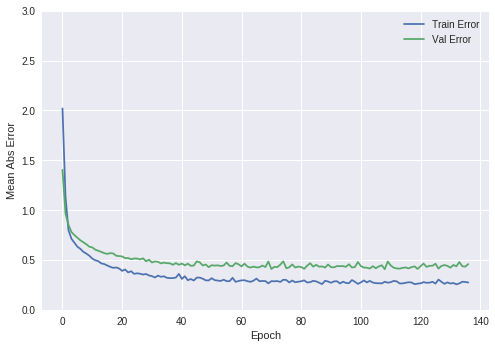

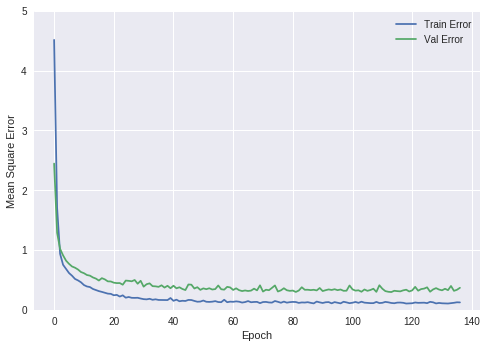

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,3])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)

**Assess model performance on test data**

In [0]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error:  0.37


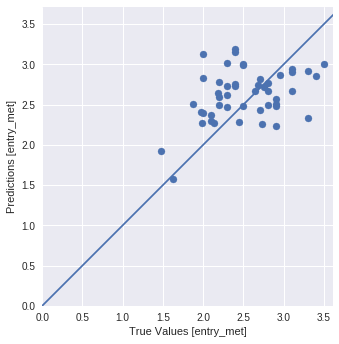

In [0]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+target_feature[0]+']')
plt.ylabel('Predictions ['+target_feature[0]+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

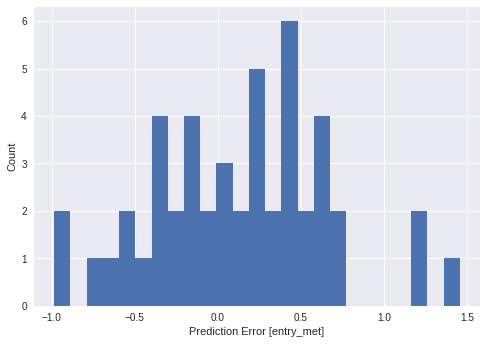

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error ['+target_feature[0]+']')
_ = plt.ylabel('Count')